In [1]:
from PIL import Image
import os
import shutil
import numpy as np
# import cv2
import re
import pickle
import random
import time
# from tqdm import tqdm
import pandas as pd 
from glob import glob
from xml.etree.ElementTree import parse
# from pascal_voc_writer import Writer
import matplotlib.pyplot as plt

import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.auto import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

# ################# DETR FUCNTIONS FOR LOSS######################## 
# import sys
# sys.path.extend(['/tmp/packages/detr/'])

# from models.matcher import HungarianMatcher
# from models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

import sys
sys.path.extend(['./util/'])
from data_parser import *
from image_prepro import *
from torchvision import transforms

In [2]:
# !pip3 install torch albumentations
# !pip3 install opencv-python
# !pip3 install torchvision

In [3]:
src_path = '/home/beomgon/Object_Detection/Dataset'
df = pd.DataFrame(columns=['label', 'org_label', 'bbox', 'xmin','ymin','xmax','ymax','width','height', 'file_name', 'path'])
# df = pd.DataFrame(columns=['class','bbox', 'path'])
data_list = []
for dir_name in ['SS', 'SS2']:
    dpath = os.path.join(src_path, dir_name)
#     print(dpath)
    dir_lists = os.listdir(dpath) 
#     print(dir_lists)
    
    for dir_list in dir_lists :
        dpath2 = os.path.join(dpath, dir_list)
        xml_list = [os.path.join(dpath2, d) for d in os.listdir(dpath2) if d.endswith(".xml")]
#         print(xml_list)
        for xml_path in xml_list :
            parser = XMLParser(xml_path)
#             if (parser.height, parser.width) not in parser.rejection_size:  
            filename = parser.file_name
            for obj in parser.objects :
#                     obj_class = obj[0]
#                     if obj_class in rej_table :
#                         continue
#                     print(obj)
                img_path = '/'.join((xml_path.split('/')[:-1])) + '/' + filename
#                 img_path = re.sub('xml', 'jpg', xml_path)
# #                     print(img_path)
                obj.append(parser.width)
                obj.append(parser.height)
                obj.append(parser.file_name)
                obj.append(img_path)
                data_list.append(obj)
# #                     print(obj)


In [4]:
df = pd.DataFrame(data_list,columns=['label', 'org_label', 'bbox', 'xmin','ymin','xmax','ymax','width','height', 'file_name', 'path'])
df = df[['label', 'org_label', 'width','height', 'bbox', 'xmin','ymin','xmax','ymax', 'file_name', 'path']]
# print(df.head())
# df = df.reset_index(drop=True)
# df.drop(columns = ['index'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,label,org_label,width,height,bbox,xmin,ymin,xmax,ymax,file_name,path
0,Carcinoma,Suamous cell carcinoma,4032,1960,"[2061, 1051, 2178, 1175]",2061,1051,2178,1175,20200623_100015.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
1,HSIL,HSIL,4032,1960,"[1945, 870, 2024, 941]",1945,870,2024,941,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
2,HSIL,HSIL,4032,1960,"[2400, 947, 2484, 1020]",2400,947,2484,1020,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
3,HSIL,HSIL,4032,1960,"[2209, 845, 2307, 912]",2209,845,2307,912,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
4,HSIL,HSIL,4032,1960,"[2056, 811, 2144, 866]",2056,811,2144,866,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...


In [5]:
x_list = []
y_list = []
h_list = []
w_list = []
for i in range(len(df)) :
    x_list.append(int((df.loc[i, 'xmin'] + df.loc[i, 'xmax'])/2))
    y_list.append(int((df.loc[i, 'ymin'] + df.loc[i, 'ymax'])/2))
    w_list.append(int((df.loc[i, 'xmax'] - df.loc[i, 'xmin'])/2))
    h_list.append(int((df.loc[i, 'ymax'] - df.loc[i, 'ymin'])/2))
df['x'] =  x_list
df['y'] =  y_list
df['w'] =  w_list
df['h'] =  h_list
df.head()

,label,org_label,width,height,bbox,xmin,ymin,xmax,ymax,file_name,path,x,y,w,h
0,Carcinoma,Suamous cell carcinoma,4032,1960,"[2061, 1051, 2178, 1175]",2061,1051,2178,1175,20200623_100015.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2119,1113,58,62
1,HSIL,HSIL,4032,1960,"[1945, 870, 2024, 941]",1945,870,2024,941,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,1984,905,39,35
2,HSIL,HSIL,4032,1960,"[2400, 947, 2484, 1020]",2400,947,2484,1020,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2442,983,42,36
3,HSIL,HSIL,4032,1960,"[2209, 845, 2307, 912]",2209,845,2307,912,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2258,878,49,33
4,HSIL,HSIL,4032,1960,"[2056, 811, 2144, 866]",2056,811,2144,866,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2100,838,44,27


In [6]:
print(set(df.label))
df.label = df.label.apply(lambda x : np.nan if x == '' else x)
print(set(df.label))
print((len(df)))
df.dropna(subset=['label'], inplace=True)
df.reset_index(drop=True, inplace=True)
print((len(df)))

{'', 'Carcinoma', 'HSIL', 'Normal', 'LSIL', 'ASCUS'}
{nan, 'Carcinoma', 'HSIL', 'Normal', 'LSIL', 'ASCUS'}
106525
101932


In [7]:
image_data = df.groupby('path')
def get_data(img_id):
    if img_id not in image_data.groups:
        return dict(image_id=img_id, label='', boxes=list())
    
    data  = image_data.get_group(img_id)
    label = data.label.values
#     label = np.unique(data.label.values)
#     assert len(label)==1, 'corrupted data: %s image_id has many labels: %s' %(img_id,label)
#     label=label[0]
    
    
    boxes = data[['x','y','w', 'h']].values
    return dict(image_id = img_id, label=label, boxes = boxes)

In [8]:
images = set(list(df['path']))
images = list(images)
image_list = [get_data(img_id) for img_id in images]

In [9]:
image_list[0]

{'image_id': '/home/beomgon/Object_Detection/Dataset/SS2/05(201021)/20201021_154906.jpg',
 'label': array(['ASCUS'], dtype=object),
 'boxes': array([[2130,  737,   62,   47]])}

In [10]:
def draw_rect(img_path, bbox_points, image_label=None, color=(0, 255, 0), thickness=5, is_normalized=False, isCenter=True):
    """ Draw rectangle
    Args:
        img: image
        bbox_points: [xmin, ymin, xmax, ymax]
        color: color rgb value
        thickness: line thickness
        is_normalized: Normalized points or not
    Return:
        img
    """
#     print(bbox_points)
    img = cv2.imread(img_path)
    img = cv2.flip(img, 1)
    h, w = img.shape[:2]
    for cls, box in zip(image_label, bbox_points) :   
        
        if cls == 'Carcinoma' or cls == 'LSIL' or cls == 'HSIL' :
            color = (255, 0, 0)
        elif cls == 'ASCUS' :
            color = (0,255,0)
        else :
            color = (0,0,255)
            
        if is_normalized:
            xmin = int(box[0] * w)
            ymin = int(box[1] * h)
            xmax = int(box[2] * w)
            ymax = int(box[3] * h)
        else:
#             xmin = int(box[0])
#             ymin = int(box[1])
#             xmax = int(box[2])
#             ymax = int(box[3])
            if isCenter :
                xmin, ymin, xmax, ymax = (box[0]-box[2], box[1]-box[3], box[0]+box[2], box[1]+box[3])
            else :
                xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
        print(xmin, ymin, xmax, ymax)
#           left high (xmin, ymin) and right low (xmax, ymax)
#         print(type(img))
#         print(color)
#         print(thickness)
#         img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)
        img = cv2.rectangle(img, (ymin, xmin), (ymax, xmax), color, thickness)
            
    return img

{'image_id': '/home/beomgon/Object_Detection/Dataset/SS/02/20200407_135915.jpg', 'label': array(['LSIL', 'LSIL'], dtype=object), 'boxes': array([[2112,  970,   94,   86],
       [2475,  370,   73,   70]])}
2018 884 2206 1056
2402 300 2548 440


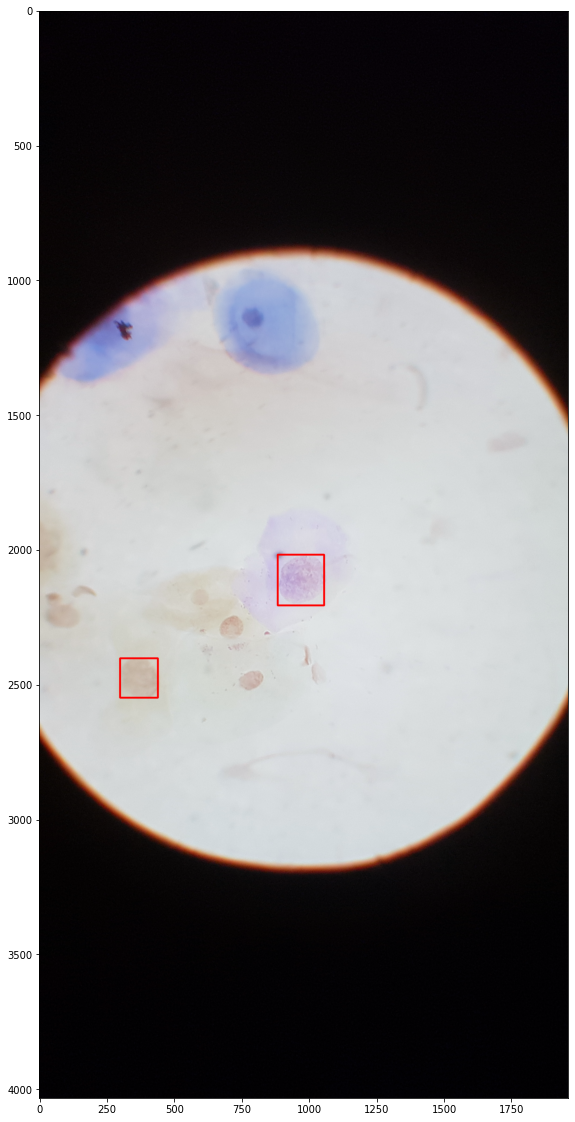

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

Image_number = 670
image_list[Image_number]
print(image_list[Image_number])
img = draw_rect(image_list[Image_number]['image_id'], image_list[Image_number]['boxes'], image_list[Image_number]['label'],isCenter=True)
# bbox = [[2337, 487, 2483, 721], [2134, 521, 2242, 635]]
# img = draw_rect(image_list[Image_number]['image_id'], bbox, image_label=['ASCUS', 'ASCUS'], isCenter=False)
plt.figure(figsize=(20, 20))
plt.imshow(img)

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

In [15]:
class AlbumentationsDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with OpenCV
        image = cv2.imread(file_path)
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image) 
            image = augmented['image']
            total_time = (time.time() - start_t)
        return image, label

In [16]:
"""
torchvision_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
"""

albumentations_transform = A.Compose([
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='coco', min_area=1024, min_visibility=0.1, label_fields=['class_labels']))

In [17]:
ADataset = AlbumentationsDataset(
    file_paths= ['20200623_100015.jpg'],
    labels = [1],
    transform=albumentations_transform)



In [19]:
# sample, label = ADataset[0]

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(transforms.ToPILImage()(sample))
plt.show()

NameError: name 'sample' is not defined

<Figure size 720x720 with 0 Axes>